In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [2]:
m = 10

def f(c):
    return np.outer(c, c)

def apply_df_dc(c, h):
    return  np.outer(c, h) + np.outer(h, c)

c0 = np.random.randn(m)
f0 = f(c0)
h = np.random.randn(m)
df_dc_h = apply_df_dc(c0, h)

s = 1e-6
c1 = c0 + s*h
f1 = f(c1)

df_dc_h_diff = (f1 - f0) / s
err_df_dc = np.linalg.norm(df_dc_h_diff - df_dc_h) / np.linalg.norm(df_dc_h_diff)
print('s=', s, ', err_df_dc=', err_df_dc)

s= 1e-06 , err_df_dc= 5.676200915456631e-07


In [3]:
def G(c):
    return 2.0 * np.dot(c, c) * np.eye(len(c)) + 2.0 * np.outer(c, c)

u = np.random.randn(m)
v = np.random.randn(m)

IP_true = np.sum(apply_df_dc(c0, u) * apply_df_dc(c0, v))

G0 = G(c0)
IP = np.dot(u, np.dot(G0, v))

err_G = np.linalg.norm(IP_true - IP) / np.linalg.norm(IP_true)
print('err_G=', err_G)

err_G= 3.3267478048986903e-16


In [4]:
def H(c, p):
    return np.dot(c, c) * np.dot(p, p) + np.dot(c, p)**2


p0 = np.random.randn(m)
H0 = H(c0, p0)
H0_true = 0.5 * np.dot(p0, np.dot(G(c0), p0))

err_hamiltonian = np.linalg.norm(H0 - H0_true) / np.linalg.norm(H0_true)
print('err_hamiltonian=', err_hamiltonian)


err_hamiltonian= 1.8518971656595465e-16


In [5]:
def dH_dc(c, p):
    return 2.0 * c * np.dot(p, p) + 2.0 * p * np.dot(c, p)

c0 = np.random.randn(m)
p0 = np.random.randn(m)
H0 = H(c0, p0)

h = np.random.randn(m)
dH_dc_h = np.dot(dH_dc(c0, p0), h)

s = 1e-6
c1 = c0 + s*h

H1 = H(c1, p0)
dH_dc_h_diff = (H1 - H0) / s

err_dH_dc = np.linalg.norm(dH_dc_h_diff - dH_dc_h) / np.linalg.norm(dH_dc_h_diff)
print('s=', s, ', err_dH_dc=', err_dH_dc)

s= 1e-06 , err_dH_dc= 1.1715774339057371e-06


In [6]:
def dH_dp(c, p):
    return 2.0 * p * np.dot(c, c) + 2.0 * c * np.dot(p, c)

c0 = np.random.randn(m)
p0 = np.random.randn(m)
H0 = H(c0, p0)

h = np.random.randn(m)
dH_dp_h = np.dot(dH_dp(c0, p0), h)

s = 1e-6
p1 = p0 + s*h

H1 = H(c0, p1)
dH_dp_h_diff = (H1 - H0) / s

err_dH_dp = np.linalg.norm(dH_dp_h_diff - dH_dp_h) / np.linalg.norm(dH_dp_h_diff)
print('s=', s, ', err_dH_dp=', err_dH_dp)

s= 1e-06 , err_dH_dp= 0.0016457947063336599


T= 1.0 , H0= 0.9211074904241792 , HT= 0.9211576531540311


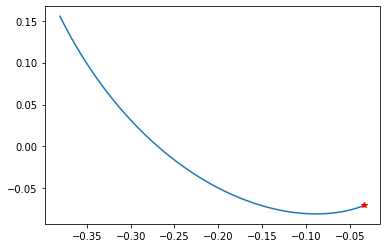

In [7]:
def cdot(c, p):
    return dH_dp(c, p)

def pdot(c, p):
    return -dH_dc(c, p)

def ydot(t, y):
    m = int(len(y)/2)
    c = y[:m]
    p = y[m:]
    return np.concatenate([cdot(c,p), pdot(c,p)])


def geodesic(c0, p0, T, num_pts=None):
    y0 = np.concatenate([c0, p0])
    if num_pts is not None:
        tt = np.linspace(0, T, num_pts)
    else:
        tt = None
    result = solve_ivp(ydot, (0.0, T), y0, t_eval=tt, method='Radau')
    cc = result.y[: len(c0), :]
    pp = result.y[len(c0) :, :]
    return cc, pp

m = 2
c0 = np.random.randn(m)
p0 = np.random.randn(m)
H0 = H(c0, p0)

T = 1.0

cc, pp = geodesic(c0, p0, T, num_pts=1000)

cT = cc[:,-1]
pT = pp[:,-1]

HT = H(cT, pT)
print('T=', T, ', H0=', H0, ', HT=', HT)

plt.plot(cc[0,:], cc[1,:])
plt.plot(cT[0], cT[1], '*r') # final point

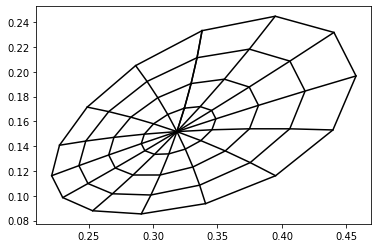

In [8]:
num_radii = 5
num_theta = 15

m = 2
c0 = np.random.randn(m)

thetas = np.linspace(0,2*np.pi, num_theta)
all_p0 = [np.array([np.sin(theta), np.cos(theta)]) for theta in list(thetas)]


T = 0.25

all_cc = np.zeros((m, num_radii, num_theta))
for ii in range(num_theta):
    p0 = all_p0[ii]
    cc, pp = geodesic(c0, p0, T, num_pts=num_radii)
    all_cc[:,:,ii] = cc

for ii in range(num_theta):
    plt.plot(all_cc[0,:,ii], all_cc[1,:,ii], 'k')
    
for jj in range(num_radii):
    plt.plot(all_cc[0,jj,:], all_cc[1,jj,:], 'k')

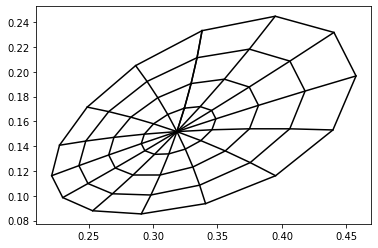

In [9]:
def exp_map(c0, p0, t):
    result = geodesic(c0, p0, t, num_pts=None)
    return result[0][:,-1], result[1][:,-1]

tt = np.linspace(0, T, num_radii)

all_cc = np.zeros((m, num_radii, num_theta))
for ii in range(num_theta):
    for jj in range(num_radii):
        p0 = all_p0[ii]
        all_cc[:,jj,ii] = exp_map(c0, all_p0[ii], tt[jj])[0]

for ii in range(num_theta):
    plt.plot(all_cc[0,:,ii], all_cc[1,:,ii], 'k')
    
for jj in range(num_radii):
    plt.plot(all_cc[0,jj,:], all_cc[1,jj,:], 'k')

In [10]:
def cdotdot(c, p):
    cd = cdot(c, p)
    pd = pdot(c, p)
    return (2.0 * pd * np.dot(c,  c) +
            4.0 * p  * np.dot(cd, c) +
            2.0 * cd * np.dot(p,  c) +
            2.0 * c  * np.dot(pd, c) +
            2.0 * c  * np.dot(p,  cd))

m = 10
c0 = np.random.randn(m)
p0 = np.random.randn(m)
cd0 = cdot(c0, p0)
cdd0 = cdotdot(c0, p0)

s = 1e-7
c1, p1 = exp_map(c0, p0, s)
cd1 = cdot(c1, p1)

cdd0_diff = (cd1 - cd0) / s
err_cdotdot = np.linalg.norm(cdd0_diff - cdd0) / np.linalg.norm(cdd0_diff)
print('s=', s, ', err_cdotdot=', err_cdotdot)

s= 1e-07 , err_cdotdot= 2.071388960252501e-06


In [11]:
def apply_dcdot_dp(c, p, h):
    return 2.0 * h * np.dot(c, c) + 2.0 * c * np.dot(h, c) # equals cdot(c,h)

m = 10
c0 = np.random.randn(m)
p0 = np.random.randn(m)
cd0 = cdot(c0, p0)
h = np.random.randn(m)
dcdot_dp_h = apply_dcdot_dp(c0, p0, h)

s = 1e-6
p1 = p0 + s*h
cd1 = cdot(c0, p1)

dcdot_dp_h_diff = (cd1 - cd0) / s

err_dcdot_dp_h = np.linalg.norm(dcdot_dp_h_diff - dcdot_dp_h) / np.linalg.norm(dcdot_dp_h_diff)
print('s=', s, ', err_dcdot_dp_h=', err_dcdot_dp_h)

s= 1e-06 , err_dcdot_dp_h= 1.4171346446991216e-10


In [12]:
def apply_dpdot_dp(c, p, h):
    return -4.0 * c * np.dot(h, p) - 2.0 * h * np.dot(c, p) - 2.0 * p * np.dot(c, h)

m = 10
c0 = np.random.randn(m)
p0 = np.random.randn(m)
pd0 = pdot(c0, p0)
h = np.random.randn(m)
dpdot_dp_h = apply_dpdot_dp(c0, p0, h)

s = 1e-6
p1 = p0 + s*h
pd1 = pdot(c0, p1)

dpdot_dp_h_diff = (pd1 - pd0) / s

err_dpdot_dp_h = np.linalg.norm(dpdot_dp_h_diff - dpdot_dp_h) / np.linalg.norm(dpdot_dp_h_diff)
print('s=', s, ', err_dpdot_dp_h=', err_dpdot_dp_h)

s= 1e-06 , err_dpdot_dp_h= 1.427068413685599e-06


In [13]:
apply_dcdot_dp_T = apply_dcdot_dp

m = 10
c0 = np.random.randn(m)
p0 = np.random.randn(m)

u = np.random.randn(m)
v = np.random.randn(m)

err_apply_dcdot_dp_T = np.dot(apply_dcdot_dp(c0, p0, u), v) - np.dot(u, apply_dcdot_dp_T(c0, p0, v))
print('err_apply_dcdot_dp_T=', err_apply_dcdot_dp_T)

err_apply_dcdot_dp_T= 3.552713678800501e-15


In [14]:
def apply_dpdot_dp_T(c, p, h):
    return -4.0 * p * np.dot(h, c) - 2.0 * h * np.dot(c, p) - 2.0 * c * np.dot(p, h)

m = 10
c0 = np.random.randn(m)
p0 = np.random.randn(m)

u = np.random.randn(m)
v = np.random.randn(m)

err_apply_dpdot_dp_T = np.dot(apply_dpdot_dp(c0, p0, u), v) - np.dot(u, apply_dpdot_dp_T(c0, p0, v))
print('err_apply_dpdot_dp_T=', err_apply_dpdot_dp_T)

err_apply_dpdot_dp_T= -3.552713678800501e-15


In [15]:
def apply_dcdotdot_dp(c, p, h):
    cd = cdot(c, p)
    pd = pdot(c, p)
    dcd = apply_dcdot_dp(c, p, h)
    dpd = apply_dpdot_dp(c, p, h)
    t1  = 2.0 * dpd * np.dot(c,   c)
    t2a = 4.0 * h   * np.dot(cd,  c) 
    t2b = 4.0 * p   * np.dot(dcd, c)
    t3a = 2.0 * dcd * np.dot(p,   c)
    t3b = 2.0 * cd  * np.dot(h,   c)
    t4  = 2.0 * c   * np.dot(dpd, c)
    t5a = 2.0 * c   * np.dot(h,   cd)
    t5b = 2.0 * c   * np.dot(p,   dcd)
    return t1 + t2a + t2b + t3a + t3b + t4 + t5a + t5b

m = 10
c0 = np.random.randn(m)
p0 = np.random.randn(m)
cdd0 = cdotdot(c0, p0)
h = np.random.randn(m)
dcdotdot_dp_h = apply_dcdotdot_dp(c0, p0, h)

s = 1e-6
p1 = p0 + s*h
cdd1 = cdotdot(c0, p1)

dcdotdot_dp_h_diff = (cdd1 - cdd0) / s

err_dcdotdot_dp_h = np.linalg.norm(dcdotdot_dp_h_diff - dcdotdot_dp_h) / np.linalg.norm(dcdotdot_dp_h_diff)
print('s=', s, ', err_dcdotdot_dp_h=', err_dcdotdot_dp_h)

s= 1e-06 , err_dcdotdot_dp_h= 6.340470924906566e-07


In [16]:
def apply_dcdotdot_dp_T(c, p, h):
    cd = cdot(c, p)
    pd = pdot(c, p)
    p_cph = apply_dpdot_dp_T(c, p, h)
    c_cpc = apply_dcdot_dp_T(c, p, c)
    c_cph = apply_dcdot_dp_T(c, p, h)
    p_cpc = apply_dpdot_dp_T(c, p, c)
    c_cpp = apply_dcdot_dp_T(c, p, p)
    t1  = 2.0 * p_cph * np.dot(c,  c)
    t2a = 4.0 * h     * np.dot(cd, c) 
    t2b = 4.0 * c_cpc * np.dot(p,  h)
    t3a = 2.0 * c_cph * np.dot(p,  c)
    t3b = 2.0 * c     * np.dot(cd, h)
    t4  = 2.0 * p_cpc * np.dot(c,  h)
    t5a = 2.0 * cd    * np.dot(c,  h)
    t5b = 2.0 * c_cpp * np.dot(c,  h)
    return t1 + t2a + t2b + t3a + t3b + t4 + t5a + t5b
    
m = 10
c0 = np.random.randn(m)
p0 = np.random.randn(m)

u = np.random.randn(m)
v = np.random.randn(m)

err_apply_dcdotdot_dp_T = np.dot(apply_dcdotdot_dp(c0, p0, u), v) - np.dot(u, apply_dcdotdot_dp_T(c0, p0, v))
print('err_apply_dcdotdot_dp_T=', err_apply_dcdotdot_dp_T)

err_apply_dcdotdot_dp_T= -1.1368683772161603e-13


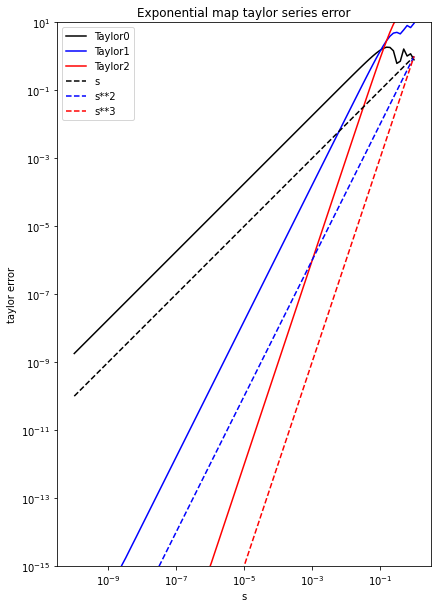

In [39]:
def exp_map_taylor0(c, p, t):
    return c

def exp_map_taylor1(c, p, t):
    return c + t * cdot(c,p)

def exp_map_taylor2(c, p, t):
    return c + t * cdot(c,p) + (t**2 / 2.0) * cdotdot(c,p)

m = 10
c0 = np.random.randn(m)
p0 = np.random.randn(m)

ss = np.logspace(-10, 0, 100)
all_err_taylor0 = np.zeros(len(ss))
all_err_taylor1 = np.zeros(len(ss))
all_err_taylor2 = np.zeros(len(ss))
for ii in range(len(ss)):
    s = ss[ii]
    es_true = exp_map(c0, p0, s)[0]
    es0 = exp_map_taylor0(c0, p0, s)
    es1 = exp_map_taylor1(c0, p0, s)
    es2 = exp_map_taylor2(c0, p0, s)

    err_taylor0 = np.linalg.norm(es0 - es_true) / np.linalg.norm(es_true)
    err_taylor1 = np.linalg.norm(es1 - es_true) / np.linalg.norm(es_true)
    err_taylor2 = np.linalg.norm(es2 - es_true) / np.linalg.norm(es_true)
    
    all_err_taylor0[ii] = err_taylor0
    all_err_taylor1[ii] = err_taylor1
    all_err_taylor2[ii] = err_taylor2
    
#     print('s=', s, ', err_taylor0=', err_taylor0, ', err_taylor1=', err_taylor1, ', err_taylor2=', err_taylor2)

plt.figure(figsize=(10,10))
plt.loglog(ss, all_err_taylor0, 'k')
plt.loglog(ss, all_err_taylor1, 'b')
plt.loglog(ss, all_err_taylor2, 'r')
plt.loglog(ss, ss, '--k')
plt.loglog(ss, ss**2, '--b')
plt.loglog(ss, ss**3, '--r')
plt.ylim(1e-15, 1e1)
plt.title('Exponential map taylor series error')
plt.xlabel('s')
plt.ylabel('taylor error')
plt.legend(['Taylor0', 'Taylor1', 'Taylor2', 's', 's**2', 's**3'])
plt.gca().set_aspect('equal')

In [63]:
def apply_dexp_map_taylor0_dp(c, p, t, h): # apply to h
    return np.zeros(c.shape)

def apply_dexp_map_taylor1_dp(c, p, t, h): # apply to h
    return t * apply_dcdot_dp(c, p, h)

def apply_dexp_map_taylor2_dp(c, p, t, h): # apply to h
    return t * apply_dcdot_dp(c, p, h) + (t**2 / 2.0) * apply_dcdotdot_dp(c, p, h)


m = 10
c0 = np.random.randn(m)
# p0 = np.random.randn(m)
p0 = np.zeros(m)
T = 0.7
eT0_0 = exp_map(c0, p0, T)[0]
eT1_0 = exp_map(c0, p0, T)[0]
eT2_0 = exp_map(c0, p0, T)[0]
# eT0_0 = exp_map_taylor0(c0, p0, T)
# eT1_0 = exp_map_taylor1(c0, p0, T)
# eT2_0 = exp_map_taylor2(c0, p0, T)

h = np.random.randn(m)
deT0_dp = apply_dexp_map_taylor0_dp(c0, p0, T, h)
deT1_dp = apply_dexp_map_taylor1_dp(c0, p0, T, h)
deT2_dp = apply_dexp_map_taylor2_dp(c0, p0, T, h)

s = 1e-7
p1 = p0 + s * h
eT0_1 = exp_map(c0, p1, T)[0]
eT1_1 = exp_map(c0, p1, T)[0]
eT2_1 = exp_map(c0, p1, T)[0]
# eT0_1 = exp_map_taylor0(c0, p1, T)
# eT1_1 = exp_map_taylor1(c0, p1, T)
# eT2_1 = exp_map_taylor2(c0, p1, T)


deT0_dp_diff = (eT0_1 - eT0_0) / s
deT1_dp_diff = (eT1_1 - eT1_0) / s
deT2_dp_diff = (eT2_1 - eT2_0) / s

err_deT0_dp = np.linalg.norm(deT0_dp_diff - deT0_dp) # should be exact zero
err_deT1_dp = np.linalg.norm(deT1_dp_diff - deT1_dp) / np.linalg.norm(deT1_dp_diff)
err_deT2_dp = np.linalg.norm(deT2_dp_diff - deT2_dp) / np.linalg.norm(deT2_dp_diff)

print('s=', s, ', err_deT0_dp=', err_deT0_dp)
print('s=', s, ', err_deT1_dp=', err_deT1_dp)
print('s=', s, ', err_deT2_dp=', err_deT2_dp)

s= 1e-07 , err_deT0_dp= 31.801146928547144
s= 1e-07 , err_deT1_dp= 4.932635115759877e-07
s= 1e-07 , err_deT2_dp= 4.932635115759877e-07


In [60]:
def apply_dexp_map_taylor0_dp_T(c, p, t, h): # apply to h
    return np.zeros(c.shape)

def apply_dexp_map_taylor1_dp_T(c, p, t, h): # apply to h
    return t * apply_dcdot_dp_T(c, p, h)

def apply_dexp_map_taylor2_dp_T(c, p, t, h): # apply to h
    return t * apply_dcdot_dp_T(c, p, h) + (t**2 / 2.0) * apply_dcdotdot_dp_T(c, p, h)

m = 10
c0 = np.random.randn(m)
p0 = np.random.randn(m)
T=0.7

u = np.random.randn(m)
v = np.random.randn(m)

err_apply_dexp_map_taylor0_dp_T = (np.dot(apply_dexp_map_taylor0_dp(c0, p0, T, u), v)
                                 - np.dot(u, apply_dexp_map_taylor0_dp_T(c0, p0,T,  v)))
print('err_apply_dexp_map_taylor0_dp_T=', err_apply_dexp_map_taylor0_dp_T)

err_apply_dexp_map_taylor1_dp_T = (np.dot(apply_dexp_map_taylor1_dp(c0, p0, T, u), v)
                                 - np.dot(u, apply_dexp_map_taylor1_dp_T(c0, p0,T,  v)))
print('err_apply_dexp_map_taylor1_dp_T=', err_apply_dexp_map_taylor1_dp_T)

err_apply_dexp_map_taylor2_dp_T = (np.dot(apply_dexp_map_taylor2_dp(c0, p0, T, u), v)
                                 - np.dot(u, apply_dexp_map_taylor2_dp_T(c0, p0,T,  v)))
print('err_apply_dexp_map_taylor2_dp_T=', err_apply_dexp_map_taylor2_dp_T)

err_apply_dexp_map_taylor0_dp_T= 0.0
err_apply_dexp_map_taylor1_dp_T= -1.4210854715202004e-14
err_apply_dexp_map_taylor2_dp_T= 0.0


In [52]:
deT0_dp_diff

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [50]:
deT0_dp

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [29]:
err_taylor0 = np.linalg.norm(es0 - es_true) / np.linalg.norm(es_true)

1.2546055344968743

In [ ]:
dcdot_dp_h_diff

In [ ]:
cdd0_diff

In [ ]:
cdd0

In [ ]:
cc100[:,-1]

In [ ]:
plt.plot(cc[0,:], cc[1,:])

In [ ]:
cc